In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, BasicAer, execute
import matplotlib.pyplot as plt
import numpy as np
from qutip import *


 TODOs

1. Assume a function f(x) that generates the gaussian distributions (relatively well behaved). How does a strategy like this works then?
My assumption is that the more stochastic the errors are in the exploration phase, the better MAB will learn. If MAB sees more data that are not similar then it'll train better.
2. Policy gradient
Assume the action space is not discrete but use gradient descent to find out the best action.
3. Put error bars on that average plot.
4. Time varying error. How do we balance between exploration and exploitation?
Use hypothesis testing. Null hypothesis is that the error does not change, alternative hypothesis is that it changes. Use how fast v0_mean_estimate or v1_mean_estimate changes to calculate some p value that will tell us that the error is changing.
5. Optimize MAB parameters.
6. How to extend this to more complicated error types?
7. Find composite pulses resistant against over-rotation and phase error.


For the state-determining circuit (where we mean state in the MDP and not quantum sense), we:
- prepare in X (+1) eigenstate
- rotate along Z axis by error theta
- measure in Y basis
Hence, p(+i) = cos^2[(pi/2-theta)/2] allowing us to distinguish between small positive and negative errors.
Note, we cannot distinguish between rotations by (pi/2 + eps, pi/2 - eps). Therefore, we assume errors lie within [-pi/2, pi/2].



In [2]:
def get_spectator_context_circuit(error_theta):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)

    qc.h(qr)

    qc.rz(error_theta, qr)

    qc.sdg(qr)
    qc.h(qr)
    qc.measure(qr, cr)

    return qc



For the reward-determining circuit, we:
- prepare in X (+1) eigenstate
- rotate along Z axis by error theta
- measure in X basis
Hence, p(+1) = cos^2[theta/2] allowing us to evaluation error correction reward.



In [3]:
def get_spectator_reward_circuit(error_theta):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)

    qc.h(qr)

    qc.rz(error_theta, qr)

    qc.h(qr)
    qc.measure(qr, cr)

    return qc



In [4]:
qc = get_spectator_context_circuit(0.1 * np.pi)
qc.draw()


In [5]:
qc_small_pos = get_spectator_context_circuit(0.1 * np.pi)
qc_small_neg = get_spectator_context_circuit(-0.1 * np.pi)
sim_pos = execute(
    qc_small_pos, backend=BasicAer.get_backend('qasm_simulator'),
    shots=1000)
sim_neg = execute(
    qc_small_neg, backend=BasicAer.get_backend('qasm_simulator'),
    shots=1000)
print(sim_pos.result().get_counts())
print(sim_neg.result().get_counts())



{'1': 352, '0': 648}
{'1': 636, '0': 364}


In [6]:
# (action, reward) distribution for a given state
# in particular, we have two states: V0, V1
# @jitclass(spec)
class MDPNode:
    def __init__(self, num_arms):
        # action set
        self.thetas = np.pi/2 * np.linspace(-1, 1, num_arms)
        # correspondingly indexed (reward | state, action) set
        # samples from beta(S, F) distribution
        self.rewards = np.ones(num_arms, dtype=np.float64)
        # (successes | arm)
        self.S = np.ones(num_arms, dtype=np.int)
        # (failures | arm)
        self.F = np.ones(num_arms, dtype=np.int)

    def resample_rewards(self):
        # rewards[arm] is drawn from beta(S[arm], F[arm]) distribution
        # which enables exploration
        for i in range(len(self.rewards)):
            self.rewards[i] = np.random.beta(self.S[i], self.F[i])

    def optimal_theta(self):
        return self.thetas[np.argmax(self.rewards)]

    def success(self):
        # update assuming success occurred when pulling currently optimal arm
        arm = np.argmax(self.rewards)
        self.S[arm] += 1

    def failure(self):
        arm = np.argmax(self.rewards)
        self.F[arm] += 1



In [7]:
def mab(error_samples, num_arms=11):
    N = len(error_samples)
    outcomes = np.zeros(N)
    V0 = MDPNode(num_arms)
    V1 = MDPNode(num_arms)

    process_fidelity_corrected = np.zeros(N)
    process_fidelity_noop = np.zeros(N)
    for i in range(N):
        spectator_qc_1 = get_spectator_context_circuit(error_samples[i])

        # single measurement of first spectator qubit
        sim_1 = execute(
            spectator_qc_1, backend=BasicAer.get_backend('qasm_simulator'),
            shots=1)
        outcome_1 = int(
            list(sim_1.result().get_counts().keys())[0]
            )
        outcomes[i] = outcome_1

        # contextual multi-arm bandit
        context = V0 if outcome_1 == 0 else V1
        context.resample_rewards()
        correction_theta = context.optimal_theta()

        # rotations along the same axis commute
        spectator_qc_2 = get_spectator_reward_circuit(
            error_samples[i] + correction_theta)
        sim_2 = execute(
            spectator_qc_2, backend=BasicAer.get_backend('qasm_simulator'),
            shots=1)
        outcome_2 = int(
            list(sim_2.result().get_counts().keys())[0]
            )

        if (outcome_2 == 0):
            context.success()
        else:
            context.failure()

        process_fidelity_corrected[i] = rz(error_samples[i] + correction_theta).tr() / 2
        process_fidelity_noop[i] = rz(error_samples[i]).tr() / 2

    return (V0, V1,
            process_fidelity_corrected, process_fidelity_noop, outcomes)



In [11]:
# unif [-alpha, alpha]
alpha_list = np.pi * np.array([0.5])

V0_sequence, V1_sequence = [], []
outcomes_sequence = []
fid_corrected_sequence, fid_noop_sequence = [], []

N = 10000
for alpha in alpha_list:
    error_samples = np.random.uniform(-alpha, alpha, N)
    V0, V1, fid_corrected, fid_noop, outcomes = mab(error_samples)

    V0_sequence.append(V0)
    V1_sequence.append(V1)
    outcomes_sequence.append(outcomes)
    fid_corrected_sequence.append(fid_corrected)
    fid_noop_sequence.append(fid_noop)



In [12]:
print(V0_sequence[0].rewards)
print(V1_sequence[0].rewards)



[0.81660914 0.80495085 0.88223702 0.91289553 0.85367544 0.50239067
 0.56985122 0.28334391 0.09167095 0.44128528 0.24212885]
[0.52844309 0.15583714 0.00381701 0.25463971 0.72130113 0.76358905
 0.8073884  0.91269884 0.87925322 0.76187927 0.03342829]


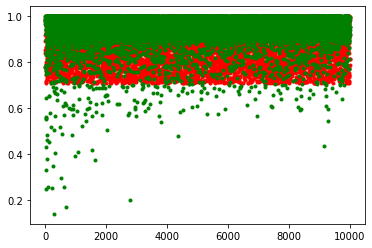

In [13]:
idx = np.linspace(1, N, N)
plt.figure()
plt.plot(idx, fid_noop_sequence[0], 'r.', idx, fid_corrected_sequence[0], 'g.')
plt.show()